In [9]:
import random
a = {1:1,2:2,3:3,4:4, 5:5, 6:6, 7:7, 8:8}
b = list(a.keys())
b = random.sample(b,len(b))
print(b)

[7, 8, 2, 4, 6, 5, 3, 1]


In [10]:
t = []
a = ['a']
b = ['b0','b1']
t += a
t += b
t

['a', 'b0', 'b1']

In [1]:
!pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.8.0-py3-none-any.whl (206 kB)


# Detect malicious users in WhatsApp public groups
* Malicious users repeatedly and intentionaly spread misinformation (bots, cyborgs, trolls)
* Low credibility / gullible users
* Superspreaders / influencers/ persuaders
* Source of fake news (SOFN)

Estimate the credibility of users

In [11]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression #logistic regression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression



#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


%matplotlib inline
sns.set(style="darkgrid")

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load expanded data

In [12]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())
df_expanded_labels = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_expanded.csv')
df['misinformation'] = df_expanded_labels['BEST_LABEL']
df.sample(10)

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma
55494,8897177310380552629,16/08/18,21:41,55,BRASIL,BRA,91,Pará,2018_15,0,0,146,24,1,2,"Nos rincões mais longínquos, temos representa...",0,"rincoes longinquos , representantes todas etni...","rinco longinqu , represent tod etn . distinca ...","rincoes longinquos , representante todo etnia ..."
119898,3759576969715223972,06/10/18,14:28,55,BRASIL,BRA,11,São Paulo,2018_33,0,0,54,7,0,1,Fiquem espertos qualquer problema informe os m...,-1,fiquem espertos qualquer problema informe mesa...,fiqu espert qualqu problem inform mesari .,ficar esperto qualquer problema informar mesar...
199343,-5641836691552196471,25/10/18,16:36,55,BRASIL,BRA,98,Maranhão,2018_49,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
233409,2485357201479715834,22/08/18,21:45,55,BRASIL,BRA,62,Goiás,2018_56,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
106473,2136294720367550533,10/09/18,08:56,55,BRASIL,BRA,61,Distrito Federal,2018_32,0,1,28,1,0,1,https://youtu.be/gjQfJGwNeOg,-1,youtube,youtub,youtube
65557,-4509021879674655331,07/10/18,14:41,55,BRASIL,BRA,38,Minas Gerais,2018_18,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
229880,1885162014068236076,28/10/18,19:11,55,BRASIL,BRA,79,Sergipe,2018_54,0,0,22,4,0,1,Ali foi primeiro turno,-1,ali primeiro turno,ali prim turn,ali primeiro turno
167052,2839535797075678550,24/09/18,10:22,55,BRASIL,BRA,63,Tocantins,2018_42,0,0,39,7,0,1,O pessoal que quiser e puder contribuir,-1,pessoal quiser puder contribuir,pessoal quis pud contribu,pessoal querer poder contribuir
195714,-2763923219368857257,07/09/18,10:01,55,BRASIL,BRA,98,Maranhão,2018_49,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
102626,1131588898586814338,11/08/18,00:59,55,BRASIL,BRA,21,Rio de Janeiro,2018_32,1,0,25,4,0,1,<Arquivo de mídia oculto>,-1,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >


In [15]:
df[df['text']=='Ali foi primeiro turno']['misinformation'].values[0]

-1

In [3]:
# update viral with expanded messages
df['viral'] = [1 if mis!=-1 else 0 for mis in df['misinformation']]

In [4]:
df['misinformation'].value_counts()

-1    258156
 0     12438
 1     12007
Name: misinformation, dtype: int64

In [5]:
## get user data from message data
# start = time.time()
# df_users = get_top_users(df,None)
# df_users.to_csv('data/2018/users.csv',index=False)
# end = time.time()
# print((end-start)/60)

df_users = pd.read_csv('data/2018/users.csv')
print(len(df_users))
df_users.sort_values('viral_misinformation_ratio', ascending=False).head(10)
# laplace smoothing, additive smoothing

5364


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,viral_messages
4669,-8996328134268937741,1,2,2,1.000000,0,0.000000,1,0.500000,199,398,92,92,1,66,66.0,0.500000,1.0,enquete presidencia ! * candidatar ? * votar v...
2031,8140300529440159518,1,23,13,0.565217,10,0.434783,4,0.173913,307,7061,169,676,4,126,504.0,0.173913,1.0,* 🚨 urgente ! ! ! * \n \n presidiario lula aut...
4474,-3816863652331327511,2,2,2,1.000000,0,0.000000,2,1.000000,283,329,116,140,2,78,91.0,1.000000,1.0,💳 trabalhar melhor 💳 \n \n trabalhar cartoes c...
557,7247843279158286574,1,124,95,0.766129,29,0.233871,6,0.048387,301,37324,162,972,6,124,744.0,0.048387,1.0,estar unir pegar filhar dum ditador guinar son...
3980,-3519169249074819778,1,4,4,1.000000,0,0.000000,2,0.500000,277,1108,146,292,2,109,218.0,0.500000,1.0,strawpoll . \n \n repassar ai pessoal pesquisa...
2805,-3234708754363031922,1,11,11,1.000000,0,0.000000,1,0.090909,139,1529,73,73,1,59,59.0,0.090909,1.0,urgente : tse acatar denunciar pt folhar decid...
3439,-8160408823789614157,1,6,2,0.333333,4,0.666667,1,0.166667,269,1614,160,160,1,118,118.0,0.166667,1.0,. * urgente * \n * audio receber grupar igreja...
4863,-6817023783809188624,1,1,1,1.000000,0,0.000000,1,1.000000,99,99,63,63,1,49,49.0,1.000000,1.0,enquete * online * presidencia * bolsonaro * *...
3477,5015889273591994616,1,6,5,0.833333,1,0.166667,3,0.500000,187,1122,101,303,3,80,240.0,0.500000,1.0,professorar globo dizer q professor . formar p...
3196,7234196746099888158,1,8,4,0.500000,4,0.500000,2,0.250000,26,208,16,32,2,13,26.0,0.250000,1.0,pesquisarrr eleitor presidenciaveis \n pesquis...


## Definitions
* **credibility:** probability of a viral message of a user don't contain misinformation
* **superspreaders or influencers:** users with high level of ``viral strenght``
* **misinformers:** users with a high number of misinformation

To consideration: users that sent a lot of viral messages may have a average or high credibility, due the quantity of information that they sent even if they sent a lot o misinformation, as user ``-9166534760459654877`` for example. So even if the user is a misinformer or superspreader, he can have high credibility by our definition. The opposite is also true, a user with low credibility may not have sent a high quantitiy of misinformation, but has a high proportion in his viral messages, as user ``	-6466419814190162853`` for example.<br>
Possible solution: use the number of misinformation (normalized between 0 and 1) in the scoring of credibility.<br>
Normalization: z = (x-min(x))/(max(x)-min(x))

* **untrustworthiness:** viral misinformation ratio smoothed by laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing)

In [6]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages'],
      dtype='object')

In [7]:
def normalization(x):
    z = (x-min(x))/(max(x)-min(x))
    return z

def get_untrustworthiness(df):
    variables = ['misinformation_strenght', 'viral_misinformation_ratio']
    z = []
    for v in variables:
        z.append(normalization(df[v]))
    z = np.array(z).transpose()
    return z.mean(axis=1)  

#df_users['untrustworthiness'] = get_untrustworthiness(df_users)
#df_users['untrustworthiness'] = normalization(df_users['untrustworthiness'])
df_users['untrustworthiness'] = df_users['misinformation']/(df_users['virals']+1)

# Distribution of activity

In [8]:
# outlier: Limite superior: Q3+1,5(Q3−Q1)
def outlier(s):
    q3 = s.quantile(0.75)
    q1 = s.quantile(0.25)
    out = q3+1.5*(q3-q1)
    return out

# Hypothesis
Most of misinformation is spread by malicious / untrustful users

In [9]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages',
       'untrustworthiness'],
      dtype='object')

## Testing the hypothesis

In [10]:
df_malicious = df_users[df_users['untrustworthiness'] >= 0.5]
malicious = set(df_malicious['id'])

# misinformation
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False
superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,malicious))    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]

print('total users:',len(df_users))
print('total untrustful users: {a:1d} ({b:.1f}%)'.format(a = len(malicious), b = len(malicious)*100/len(df_users)))
print('proportion of misinformation sent by untrustful users: {a:.1f}%'.format(a = len(df_superspreaders)*100/total_mis))

total misinformation:  12007
total users: 5364
total untrustful users: 1311 (24.4%)
proportion of misinformation sent by untrustful users: 71.9%


# Selecting only the active users based in data

In [14]:
# user data
df_active_users = df_users[(df_users['virals'] > 0)]

In [15]:
print('trustable users?')
df_active_users[df_active_users['untrustworthiness'] == 0]

trustable users?


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,viral_messages,untrustworthiness
19,-3545133711641780471,1,932,873,0.936695,59,0.063305,19,0.020386,272,253504,125,2375,0,76,0.0,0.0,0.0,twitter .<>kkk<>kkk<>kkk<>kkk<>kkk<>kkk<>kkk<>...,0.0
53,-3161726312974583913,1,622,492,0.790997,130,0.209003,3,0.004823,269,167318,160,480,0,118,0.0,0.0,0.0,kkk<>kkk<>kkk,0.0
91,5799803585252829017,1,450,384,0.853333,66,0.146667,2,0.004444,272,122400,125,250,0,76,0.0,0.0,0.0,oi galera . . . . . independente vcs irao vota...,0.0
114,5156564419463006011,1,398,344,0.864322,54,0.135678,9,0.022613,301,119798,162,1458,0,124,0.0,0.0,0.0,kkk<>kkk<>kkk<>kkk<>kkk<>kkk<>[num] 💨 💨 💨<>kkk...,0.0
178,-3198159623833756640,1,304,145,0.476974,159,0.523026,3,0.009868,152,46208,96,288,0,72,0.0,0.0,0.0,petista procurar teta segundo feirar<>marinho ...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5178,-4150583708362526636,1,1,1,1.000000,0,0.000000,1,1.000000,199,199,92,92,0,66,0.0,0.0,0.0,"* gente ir tomar cuidar nao perder amizade , a...",0.0
5179,-4188663224858239237,1,1,1,1.000000,0,0.000000,1,1.000000,93,93,57,57,0,47,0.0,0.0,0.0,* avisar utilidade publicar * \n \n brasil par...,0.0
5250,-5214655400732106639,1,1,1,1.000000,0,0.000000,1,1.000000,139,139,73,73,0,59,0.0,0.0,0.0,ir fazer campanha inteligente garantir vitoria...,0.0
5283,-2988991460937333560,1,1,1,1.000000,0,0.000000,1,1.000000,164,164,68,68,0,42,0.0,0.0,0.0,acesse link entrar grupar whatsapp : chat . wh...,0.0


# User representation

In [16]:
user_features = ['number_of_messages', 'texts', 'text_ratio', 'midia',
           'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
           'viral_degree_centrality', 'viral_strenght']
X = df_active_users[user_features]
y = df_active_users['untrustworthiness']
X.shape

(2826, 11)

### Feature selection

In [17]:
# univariate analysis
X.std()

number_of_messages           180.914085
texts                        119.136730
text_ratio                     0.237966
midia                         82.780879
midia_ratio                    0.237966
virals                        21.300820
viral_ratio                    0.180458
degree_centrality            144.511647
strenght                   38299.616581
viral_degree_centrality       80.755523
viral_strenght              2273.075320
dtype: float64

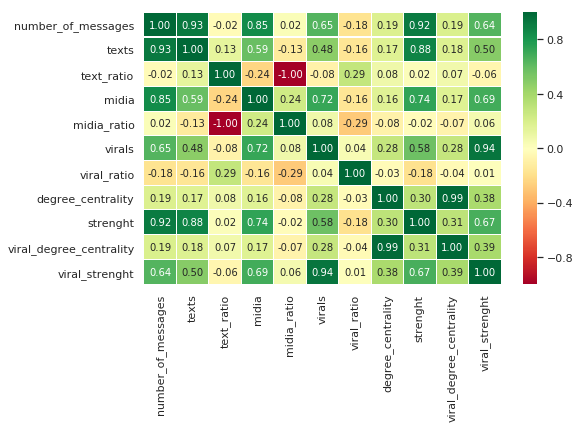

In [18]:
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,5))
#plot heat map
# sns.heatmap(df_similar, annot=True, fmt='.2f', linewidths=.1)
g=sns.heatmap(X[top_corr_features].corr(),annot=True, fmt='.2f', linewidths=.1,cmap="RdYlGn")

[0.06194484 0.08096987 0.0625208  0.05285846 0.10528862 0.12711629
 0.10660643 0.09143291 0.15494479 0.05866295 0.09765403]


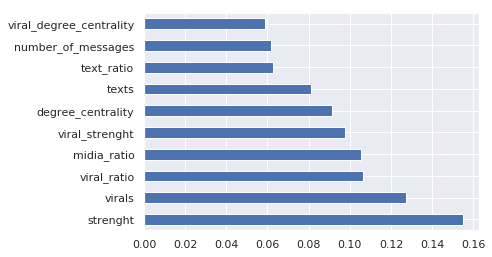

In [19]:
# feature importance

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Evaluation functions

In [20]:
def pred_tfidf(reg,X_test):
    y_pred = []
    for x in X_test:
    #if vector is from null text
        if x.sum()==0:
            y_pred.append(.0)
        else:
            pred = reg.predict(x)[0]
            y_pred.append(pred)
    return y_pred

def pred_topics(reg,X_test):
    y_pred = []
    for x in X_test:
    #if vector is from null text
        if np.all(x == x[0]):
            y_pred.append(0.0)
        else:
            pred = reg.predict(x)[0]
            y_pred.append(pred)
    return y_pred

def train_test_reg(reg,X_train,X_test,y_train,y_test, text_features = None):
    reg.fit(X_train, y_train)

    if text_features == 'tfidf':
        y_pred = pred_tfidf(reg,X_test)
    elif text_features == 'lda':
        y_pred = pred_topics(reg,X_test)
    else:
        y_pred = reg.predict(X_test)
        
    y_pred = np.clip(y_pred,0,1)    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print('rmse: {a:.3f}'.format(a=rmse))
    return rmse,y_pred

def z_score(X_train,X_test):
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_train = (X_train - mu ) / sigma
    X_test = (X_test - mu ) / sigma
    return X_train,X_test

def compare_prediction(y,y_pred):
    for t,p in list(zip(y,y_pred)):
        print('real: {a:.2f}. predict: {b:.2f}'.format(a=t,b=p))
        
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    

# compare prediction with target

# for t,p in list(zip(y_test,y_pred)):
#     print('real: {a:.2f}. predict: {b:.2f}'.format(a=t,b=p))

In [21]:
# optimal mlp for tfidf
def get_mlp():
    reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 5, max_iter = 100,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return reg

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,5)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_rmse = 1000
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        reg = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        reg.fit(X_train_v, y_train_v)
        y_pred = reg.predict(X_val)        
        y_pred = np.clip(y_pred,0,1)

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (hl,bs,al,lri)

        print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation rmse = {a:.3f})'.format(a=best_rmse))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 5, max_iter = 200,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return reg
    
    

# Predict untrustworthness using user activity as features

In [22]:
user_features = ['number_of_messages','midia_ratio', 'viral_ratio', 
                 'degree_centrality', 'strenght',
                 'viral_degree_centrality', 'viral_strenght']
X = df_active_users[user_features]
y = df_active_users['untrustworthiness']
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# z_score
X_train,X_test=z_score(X_train,X_test)
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(2826, 7)
(2260, 7)
(566, 7)


In [ ]:
reg = LinearRegression()
print('linear regression + user features')
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

In [ ]:
#compare_prediction(y_test,y_pred)

In [33]:
print('mlp + user features')
reg = MLPRegressor(random_state=0,)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)
#compare_prediction(y_test,y_pred)

mlp + user features
rmse: 0.224


In [38]:
reg = get_mlp()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

rmse: 0.228


In [39]:
print('mlp + user features')
hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
reg = optimized_mlp(hl,bs,al,lri)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + user features
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
validation rmse: 0.235
1 
hidden layers: (100, 150); alpha: 0.00003; learning rate: 0.00078; batch: 50
validation rmse: 0.232
2 
hidden layers: (325,); alpha: 0.00003; learning rate: 0.02372; batch: 200
validation rmse: 0.233
3 
hidden layers: (225, 50, 150); alpha: 0.00221; learning rate: 0.00103; batch: 50
validation rmse: 0.229
4 
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
validation rmse: 0.227
5 
hidden layers: (100, 225, 50); alpha: 0.00007; learning rate: 0.02196; batch: 150
validation rmse: 0.231
6 
hidden layers: (50,); alpha: 0.00000; learning rate: 0.06823; batch: 200
validation rmse: 0.229
7 
hidden layers: (125, 200, 100); alpha: 0.00001; learning rate: 0.01625; batch: 50
validation rmse: 0.229
8 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 50
validation rmse: 0.229
9 
hidden layers: (125, 250); alpha: 0.00006; lear

# Text features

In [40]:
X = df_active_users['viral_messages']
y = df_active_users['untrustworthiness']
X_texts_train, X_texts_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# nan_mask = X_texts_train.notna().values
# X_texts_train = X_texts_train[nan_mask]
# y_train = y_train[nan_mask]
# print(y_train.shape)
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]

In [41]:
# tf-idf
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), 
                             lowercase = True, token_pattern = r'[^\s]+')
vectorizer.fit(X_texts_train)   
X_train = vectorizer.transform(X_texts_train)
X_test = vectorizer.transform(X_texts_test)
X_train.shape

(2260, 149386)

In [42]:
print('linear regression + tfidf')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + tfidf
rmse: 0.250


In [43]:
reg = MLPRegressor(random_state=0)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

rmse: 0.165


In [44]:
print('mlp + tfidf')
hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
reg = optimized_mlp(hl,bs,al,lri)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
validation rmse: 0.180
1 
hidden layers: (100, 150); alpha: 0.00003; learning rate: 0.00078; batch: 50
validation rmse: 0.176
2 
hidden layers: (325,); alpha: 0.00003; learning rate: 0.02372; batch: 200
validation rmse: 0.182
3 
hidden layers: (225, 50, 150); alpha: 0.00221; learning rate: 0.00103; batch: 50
validation rmse: 0.176
4 
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
validation rmse: 0.182
5 
hidden layers: (100, 225, 50); alpha: 0.00007; learning rate: 0.02196; batch: 150
validation rmse: 0.190
6 
hidden layers: (50,); alpha: 0.00000; learning rate: 0.06823; batch: 200
validation rmse: 0.240
7 
hidden layers: (125, 200, 100); alpha: 0.00001; learning rate: 0.01625; batch: 50
validation rmse: 0.184
8 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 50
validation rmse: 0.185
9 
hidden layers: (125, 250); alpha: 0.00006; learning rat

# Combine user features and TF-IDF

In [23]:
X = df_active_users[user_features+['viral_messages']]
y = df_active_users['untrustworthiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_texts = X_train['viral_messages']
X_test_texts = X_test['viral_messages']

X_train = X_train[user_features].to_numpy()
X_test = X_test[user_features].to_numpy()
X_train, X_test = z_score(X_train,X_test)

vectorizer = TfidfVectorizer(max_features = 6000, ngram_range = (1,1), lowercase = True, token_pattern = r'[^\s]+')
vectorizer.fit(X_train_texts)   
X_train_tfidf = vectorizer.transform(X_train_texts).todense()
X_test_tfidf = vectorizer.transform(X_test_texts).todense()

X_train = np.concatenate((X_train, X_train_tfidf), axis=1)
X_test = np.concatenate((X_test, X_test_tfidf), axis=1)
X_train.shape


(2260, 6007)

In [46]:
print('linear regression + user features + tfidf')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + user features + tfidf
rmse: 0.512


In [24]:
print('mlp + user features + tfidf')
# hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
# reg = optimized_mlp(hl,bs,al,lri)
reg = get_mlp()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + user features + tfidf
rmse: 0.152


# Classify fake news by users credibility
## Medium score
* Consider the mean credibility of users that posted a message
* Remove duplicates

In [73]:
def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')

# Load messages data

In [74]:
# load and select message data

# load expanded data
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
corpus = list(df[df['midia']==0]['preprocessed_text_lemma'].unique())
df_expanded_labels = pd.read_csv('data/2018/fakeWhatsApp.BR_2018_expanded.csv')
df['misinformation'] = df_expanded_labels['BEST_LABEL']

# sorting by time
def custom_time(data,hora):
    string = data + " " + hora
    return string
df['timestamp'] = df.apply(lambda x: custom_time(x['date'],x['hour']),axis=1)
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%y %H:%M')
df.sort_values(by='timestamp',inplace=True)

#removing duplicates and selecting only labelled data
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]

# filter noisy messages
df = df[df['words']>10]
df['types_chars'] = [len(set(t)) for t in df['text']]
df = df[df['types_chars']>15]

# include in viral category automatically labeled messages
df['viral'] = [1 if mis!=-1 else 0 for mis,vir in zip(df['misinformation'],df['viral'])]
df = df[df['viral']==1]

df.reset_index(drop=True,inplace=True)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
import math

In [76]:
df_unique = df.drop_duplicates(subset='text')
texts = list(df_unique['preprocessed_text_lemma'])
y = df_unique['misinformation']
#X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

cut = math.floor(len(y)*0.8)
X_train_texts = texts[0:cut]
y_train= y[0:cut]
X_test_texts = texts[cut:]
y_test = y[cut:]

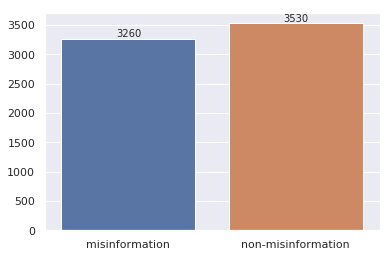

In [77]:
print_class_balance(y)

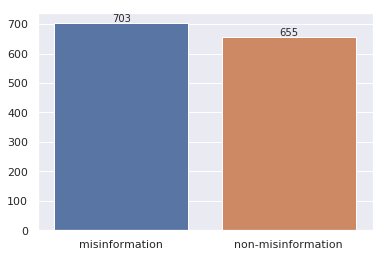

In [78]:
print_class_balance(y_test)

In [79]:
print(y.sum()/len(y))

0.4801178203240059


In [80]:
# collect only train text data
user_train_texts = []
users = df_active_users['id']

for user in users:
    texts = df[df['id']==user]['preprocessed_text_lemma']
    train_texts = [t for t in texts if t in X_train_texts]
    train_texts = ['' if type(t)!=str else t for t in train_texts]
    train_texts = ' '.join(train_texts)
    user_train_texts.append(train_texts)

X_users_texts = user_train_texts
y_users = df_active_users['untrustworthiness']

In [81]:
vectorizer = TfidfVectorizer(max_features = 6000, ngram_range = (1,1), lowercase = True, token_pattern = r'[^\s]+')
X_tfidf = vectorizer.fit_transform(X_users_texts)

In [82]:
X_tfidf.shape

(2826, 6000)

In [83]:
X_user_features = df_active_users[user_features].to_numpy()
X_user_features, z = z_score(X_user_features, X_user_features)
X_tfidf = X_tfidf.todense()
X_users = np.concatenate((X_user_features, X_tfidf), axis=1)
X_users.shape

(2826, 6007)

In [84]:
# reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
#                    tol = 1e-4, verbose = True, early_stopping = True, 
#                    n_iter_no_change = 3, max_iter = 10,
#                    hidden_layer_sizes = (100,), alpha = 0.0067, 
#                    learning_rate_init = .00026, batch_size = 50)
reg = MLPRegressor()
reg.fit(X_users,y_users)

MLPRegressor()

In [85]:
y_pred = reg.predict(X_users)
y_pred = np.clip(y_pred,0,1)    
rmse = mean_squared_error(y_users, y_pred, squared=False)
print(rmse)

0.16400060111649944


In [86]:
# get mean credibility of users that sent the news
user_dict = dict(zip(df_active_users['id'], y_pred))
message_score = []
for m in X_test_texts:
    df_msg = df[df['preprocessed_text_lemma']==m]
    users = df_msg['id']
    scores = []
    for u in users:
        scores.append(user_dict.get(u, 0.5))
    user_score = pd.Series(index=users,data = scores)
    message_score.append(user_score.mean())

In [87]:
from sklearn.metrics import accuracy_score
def optimal_threshold(prob,y):
    best_thresold = 0
    best_score = 0
    
    for i in range(100):
        threshold = i/100
        y_pred = [1 if p >= threshold else 0 for p in prob]
        score = accuracy_score(y,y_pred)
        
        if score > best_score:
            #print(score)
            best_thresold = threshold
            best_score = score
            
    return best_thresold, best_score

In [88]:
mis = ['misinformation' if m == 1 else 'non-misinformation' for m in y_test]
df_print = pd.DataFrame({'class':mis,'score':message_score})

0.49


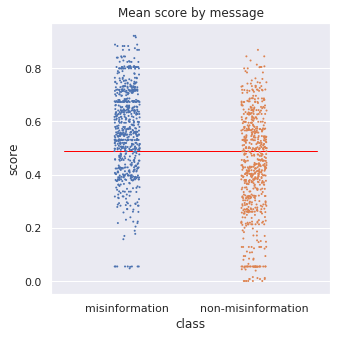

In [89]:
thr, acc = optimal_threshold(message_score,y_test)    
print(thr)

threshold = thr
plt.figure(figsize=(5,5))
plt.title('Mean score by message')
sns.stripplot(x='class' ,y='score', size=2, data = df_print)
plt.plot([-.5,1.5], [threshold, threshold], linewidth=1, color = 'red')

              precision    recall  f1-score   support

           0       0.65      0.59      0.62       655
           1       0.65      0.71      0.68       703

    accuracy                           0.65      1358
   macro avg       0.65      0.65      0.65      1358
weighted avg       0.65      0.65      0.65      1358

AUC:  0.7024605561769082


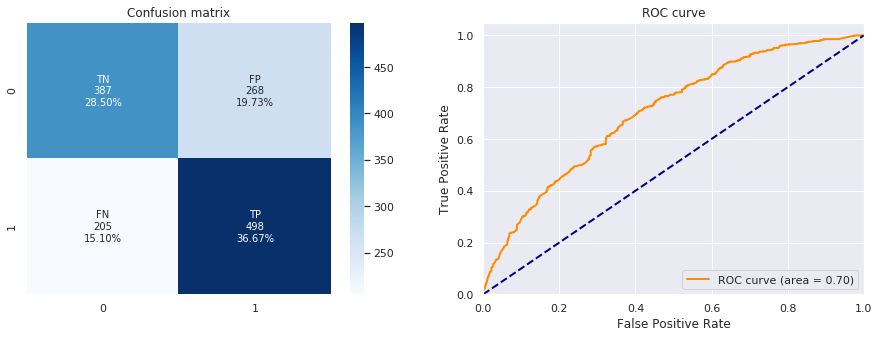

(0.6516936671575847,
 0.6501305483028721,
 0.6206896551724138,
 0.7083926031294452,
 0.6206896551724138,
 0.6780122532334921,
 0.6206896551724138,
 0.7024605561769082)

In [90]:
y_pred_mis = [1 if x >= threshold else 0 for x in message_score]
get_test_metrics(y_test, y_pred_mis, message_score, full_metrics = True)

# Combine with text predictor

In [91]:
vectorizer = CountVectorizer(max_features = None, ngram_range = (1,3), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True) #CountVectorizer #TfidfVectorizer
vectorizer.fit(X_train_texts)   
X_train_bow = vectorizer.transform(X_train_texts)
X_test_bow = vectorizer.transform(X_test_texts)
X_train_bow.shape

(5432, 329395)

In [108]:
print('logistic regression + bow')
clf = LogisticRegression()
clf.fit(X_train_bow, y_train)
y_prob = clf.predict_proba(X_test_bow)[:,1]
y_prob_train = clf.predict_proba(X_train_bow)[:,1]

logistic regression + bow


In [113]:
y_prob.shape

(1358,)

In [93]:
# get mean credibility of users that sent the news
message_score_train = []
for m in X_train_texts:
    df_msg = df[df['preprocessed_text_lemma']==m]
    users = df_msg['id']
    scores = []
    for u in users:
        scores.append(user_dict.get(u, 0.5))
    user_score = pd.Series(index=users,data = scores)
    message_score_train.append(user_score.mean())

In [111]:
user_score_train = np.array(message_score_train)
user_score = np.array(message_score)
user_score.shape

(1358,)

In [116]:
X2.shape

(1358, 2)

0.27
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       655
           1       0.84      0.79      0.82       703

    accuracy                           0.82      1358
   macro avg       0.82      0.82      0.82      1358
weighted avg       0.82      0.82      0.82      1358

AUC:  0.8960833070917442


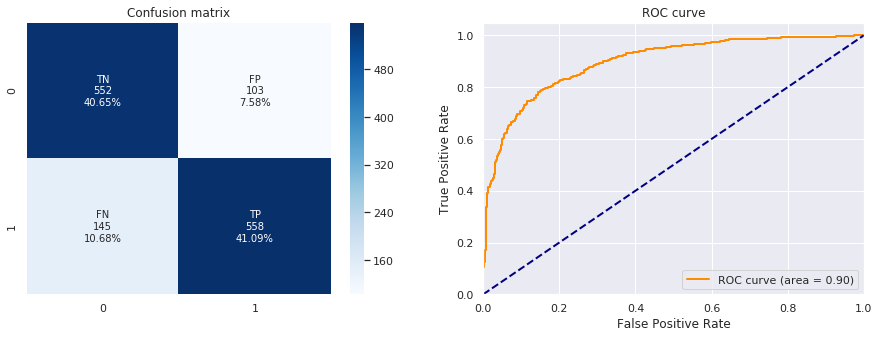

(0.8173784977908689,
 0.8441754916792739,
 0.8165680473372782,
 0.7937411095305832,
 0.8165680473372782,
 0.8181818181818181,
 0.8165680473372782,
 0.8960833070917442)

In [117]:
# using logistic regression for best weights

text_prob = y_prob_train.reshape((len(y_prob_train),1))
user_prob = user_score_train.reshape((len(y_prob_train),1))
X2 = np.concatenate((text_prob,user_prob),axis = 1)
clf2 = LogisticRegression()
clf2.fit(X2, y_train)

text_prob = y_prob.reshape((len(y_prob),1))
user_prob = user_score.reshape((len(user_score),1))
X2 = np.concatenate((text_prob, user_prob),axis = 1)

y_mix_prob = clf2.predict_proba(X2)[:,1]

# threshold moving
thr, acc = optimal_threshold(y_mix_prob,y_test)    
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_mix_prob]
get_test_metrics(y_test, y_pred, y_mix_prob, full_metrics = True)

In [96]:
W0 = list(range(0,10))
W1 = list(range(0,10))
best_w0 = 0
best_w1 = 0
best_score = 0

for w0 in W0:
    for w1 in W1:
        y_mix_prob = (w0*y_prob_train + w1*user_score_train)/(w1+w0)
        thr, acc = optimal_threshold(y_mix_prob,y_train)    
        y_pred = [1 if p >= thr else 0 for p in y_mix_prob]
        score = accuracy_score(y_train,y_pred)
        if score > best_score:
            best_score = score
            best_w0 = w0
            best_w1 = w1
            
print(best_w0,best_w1,best_score)
        
        

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


1 0 0.9998159057437408


In [97]:
y_mix_prob = (best_w0*y_prob+best_w1*user_score)/(best_w0+best_w1)

0.42
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       655
           1       0.85      0.79      0.82       703

    accuracy                           0.82      1358
   macro avg       0.82      0.82      0.82      1358
weighted avg       0.82      0.82      0.82      1358

AUC:  0.8940158318221798


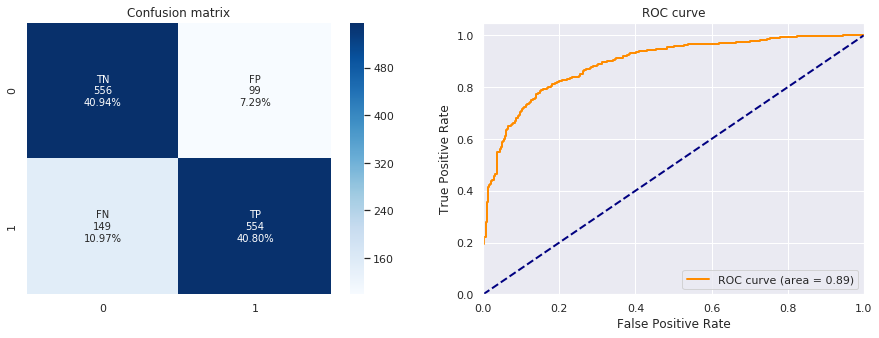

(0.8173784977908689,
 0.8483920367534457,
 0.8176470588235295,
 0.7880512091038406,
 0.8176470588235295,
 0.8171091445427728,
 0.8176470588235295,
 0.8940158318221798)

In [98]:
# threshold moving
thr, acc = optimal_threshold(y_mix_prob,y_test)    
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_mix_prob]
get_test_metrics(y_test, y_pred, y_mix_prob, full_metrics = True)

In [99]:
y_mix_prob = (y_prob+user_score)/2

0.5
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       655
           1       0.86      0.79      0.82       703

    accuracy                           0.82      1358
   macro avg       0.82      0.82      0.82      1358
weighted avg       0.82      0.82      0.82      1358

AUC:  0.8876896181034389


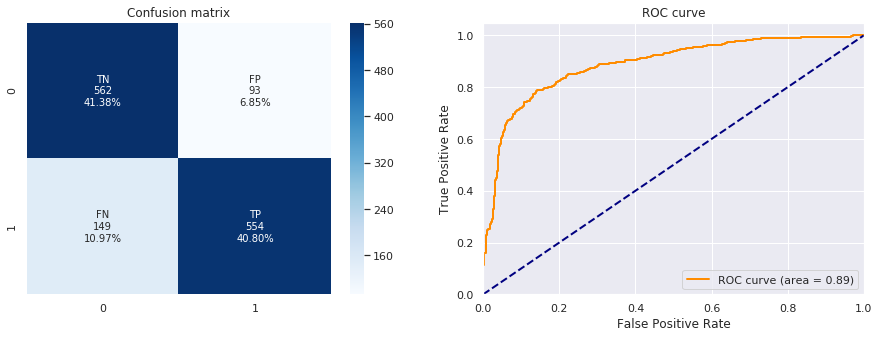

(0.8217967599410898,
 0.8562596599690881,
 0.8228404099560761,
 0.7880512091038406,
 0.8228404099560761,
 0.8207407407407408,
 0.8228404099560761,
 0.8876896181034389)

In [100]:
# threshold moving
thr, acc = optimal_threshold(y_mix_prob,y_test)    
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_mix_prob]
get_test_metrics(y_test, y_pred, y_mix_prob, full_metrics = True)

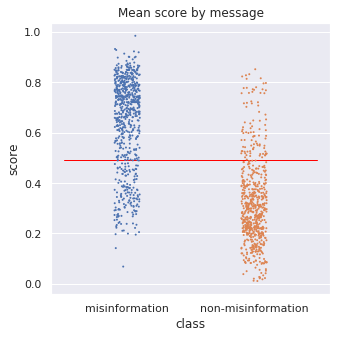

In [71]:
df_print = pd.DataFrame({'class':mis,'score':y_mix_prob})
threshold = thr
plt.figure(figsize=(5,5))
plt.title('Mean score by message')
sns.stripplot(x='class' ,y='score', size=2, data = df_print)
plt.plot([-.5,1.5], [threshold, threshold], linewidth=1, color = 'red')

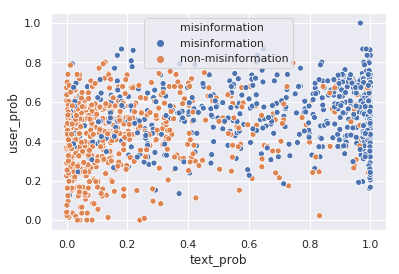

In [72]:
df_print_scores = pd.DataFrame({'text_prob':y_prob,'user_prob':user_score,'misinformation':mis})
sns.scatterplot(data=df_print_scores,x = 'text_prob', y = 'user_prob', hue = 'misinformation')

# Identifying superspreaders
Users that shared a lot of fake news

In [73]:
df_users.head(3)

,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,viral_messages,untrustworthiness
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,61,0.013876,152,668192,96,5856,13,72,936.0,0.002957,0.213115,"kkk<>kkk<>kkk<>- casar poder ajudar , colocar ...",0.209677
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,257,0.110206,1640,498105,936,30402,78,720,6955.0,0.033448,0.303502,"apo tres escola militar irar final soletrar , ...",0.302326
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,246,0.119186,525,389426,307,25786,89,246,7169.0,0.043120,0.361789,kkk urna sao fraudar kkk desculpar ha ja dar n...,0.360324


count     5364.000000
mean       166.905108
std        602.234514
min          0.000000
25%          0.000000
50%          0.000000
75%        109.000000
max      11748.000000
Name: misinformation_strenght, dtype: float64

outliers 272.5


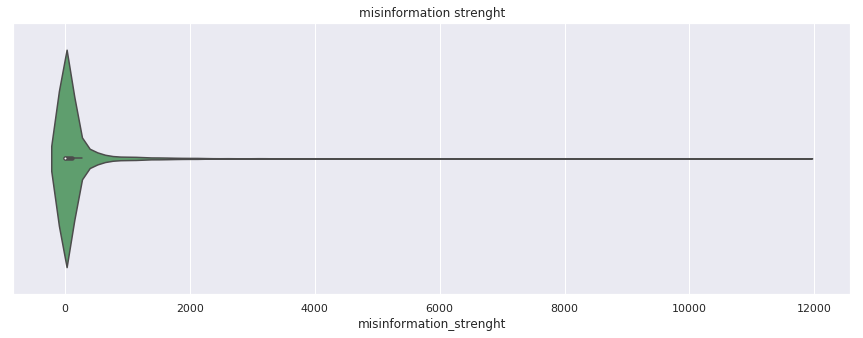

In [74]:
# absolute value
values = df_users['misinformation_strenght']
plt.figure(figsize=(15,5))
plt.title('misinformation strenght')
ax = sns.violinplot(x=values, color = 'C2')
print(values.describe())
print()
print('outliers',outlier(values))
mis_strenght_threshold = outlier(values)

In [75]:
df_malicious = df_users[df_users['misinformation_strenght'] >= mis_strenght_threshold]
malicious = set(df_malicious['id'])

# misinformation
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False
superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,malicious))    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]

print('total users:',len(df_users))
print('total untrustful users: {a:1d} ({b:.1f}%)'.format(a = len(malicious), b = len(malicious)*100/len(df_users)))
print('proportion of misinformation sent by untrustful users: {a:.1f}%'.format(a = len(df_superspreaders)*100/total_mis))

total misinformation:  3260
total users: 5364
total untrustful users: 690 (12.9%)
proportion of misinformation sent by untrustful users: 75.1%


In [76]:
df_users['superspreader'] = [1 if m > mis_strenght_threshold else 0 for m in df_users['misinformation_strenght']]

count     5364.000000
mean       466.238814
std       1707.907963
min          0.000000
25%          0.000000
50%         32.000000
75%        292.000000
max      51411.000000
Name: viral_strenght, dtype: float64

outliers 730.0


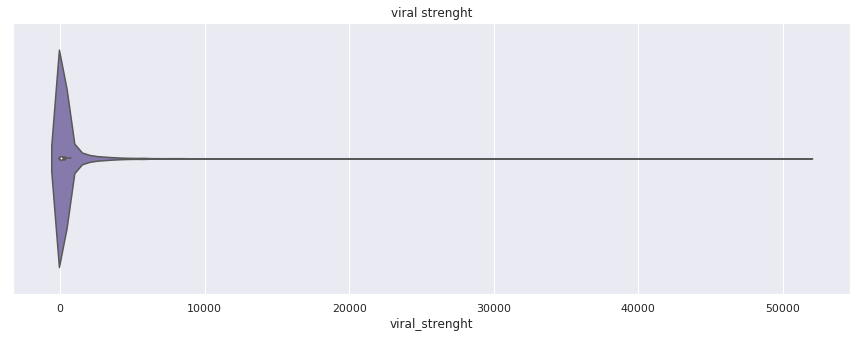

In [77]:
# relative to users value

values = df_users['viral_strenght']
plt.figure(figsize=(15,5))
plt.title('viral strenght')
ax = sns.violinplot(x=values, color = 'C4')
print(values.describe())
print()
print('outliers',outlier(values))

viral_strenght_threshold = outlier(values)

# Detection by threshold

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4674
           1       0.80      0.83      0.81       690

    accuracy                           0.95      5364
   macro avg       0.89      0.90      0.89      5364
weighted avg       0.95      0.95      0.95      5364



(0.9509694258016406,
 0.7986013986013986,
 0.9717901962887483,
 0.827536231884058,
 0.9717901962887483,
 0.8128113879003559,
 0.9717901962887483,
 0)

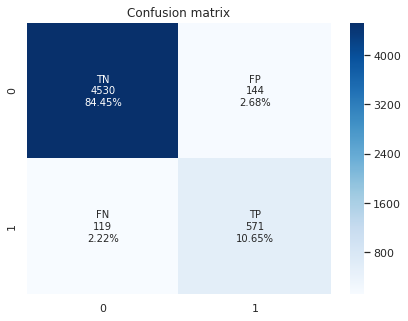

In [78]:
# only by viral strenght outlier and without train-test split
y = df_users['superspreader']
y_pred = [1 if m > viral_strenght_threshold else 0 for m in df_users['viral_strenght']]
get_test_metrics(y, y_pred, full_metrics = True)

## Using credibility models

In [79]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages',
       'untrustworthiness', 'superspreader'],
      dtype='object')

In [80]:
# using credibility
X = df_users[user_features + ['viral_messages']]
y = df_users[['untrustworthiness','superspreader']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_texts_train = X_train['viral_messages']
X_texts_test = X_test['viral_messages']

X_train_users = X_train[user_features].to_numpy()
X_test_users = X_test[user_features].to_numpy()

X_train_users, X_test_users = z_score(X_train_users, X_test_users)

y_train = y_train['untrustworthiness']
y_test_untrust = y_test['untrustworthiness']

y_test_superspreader = y_test['superspreader']
X_test_viral = X_test['viral_strenght']

In [81]:
# tf-idf
X_texts_train = ['' if type(x) != str else x for x in X_texts_train]
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]
vectorizer = TfidfVectorizer(max_features = 6000, ngram_range = (1,1), lowercase = True, token_pattern = r'[^\s]+')
vectorizer.fit(X_texts_train)   
X_train_tfidf = vectorizer.transform(X_texts_train).todense()
X_test_tfidf = vectorizer.transform(X_texts_test).todense()

X_users_train = np.concatenate((X_train_users, X_train_tfidf), axis=1)
X_users_test = np.concatenate((X_test_users, X_test_tfidf), axis=1)

X_train_tfidf.shape

(4291, 6000)

In [82]:
print('linear regression + tfidf')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_users_train,X_users_test,y_train,y_test_untrust)

linear regression + tfidf
rmse: 0.370


In [83]:
reg = MLPRegressor()
rmse, y_pred = train_test_reg(reg,X_users_train,X_users_test,y_train,y_test_untrust)

rmse: 0.121


In [84]:
compare_prediction(y_test_untrust,y_pred)

real: 0.00. predict: 0.00
real: 0.33. predict: 0.38
real: 0.00. predict: 0.07
real: 0.80. predict: 0.59
real: 0.00. predict: 0.00
real: 0.36. predict: 0.39
real: 0.50. predict: 0.21
real: 0.00. predict: 0.00
real: 0.00. predict: 0.01
real: 0.00. predict: 0.01
real: 0.29. predict: 0.50
real: 0.50. predict: 0.68
real: 0.41. predict: 0.40
real: 0.33. predict: 0.33
real: 0.00. predict: 0.00
real: 0.00. predict: 0.00
real: 0.00. predict: 0.01
real: 0.00. predict: 0.01
real: 0.00. predict: 0.00
real: 0.00. predict: 0.00
real: 0.46. predict: 0.48
real: 0.00. predict: 0.00
real: 0.00. predict: 0.01
real: 0.00. predict: 0.00
real: 0.33. predict: 0.24
real: 0.67. predict: 0.14
real: 0.00. predict: 0.00
real: 0.00. predict: 0.00
real: 0.40. predict: 0.27
real: 0.00. predict: 0.02
real: 0.00. predict: 0.00
real: 0.29. predict: 0.33
real: 0.00. predict: 0.19
real: 0.00. predict: 0.00
real: 0.33. predict: 0.49
real: 0.00. predict: 0.02
real: 0.33. predict: 0.44
real: 0.25. predict: 0.48
real: 0.00. 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       916
           1       0.81      0.80      0.81       157

    accuracy                           0.94      1073
   macro avg       0.89      0.88      0.89      1073
weighted avg       0.94      0.94      0.94      1073



(0.9431500465983225,
 0.8076923076923077,
 0.966721222040371,
 0.802547770700637,
 0.966721222040371,
 0.805111821086262,
 0.966721222040371,
 0)

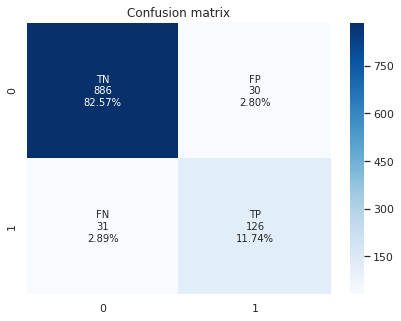

In [85]:
# without credibility
y_pred_rule = [1 if m > viral_strenght_threshold else 0 for m in X_test_viral]
get_test_metrics(y_test_superspreader, y_pred_rule, full_metrics = True)

In [86]:
viral_strenght_threshold

730.0

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       916
           1       0.82      0.80      0.81       157

    accuracy                           0.95      1073
   macro avg       0.89      0.89      0.89      1073
weighted avg       0.94      0.95      0.94      1073



(0.9450139794967382,
 0.8181818181818182,
 0.9678474114441417,
 0.802547770700637,
 0.9678474114441417,
 0.8102893890675242,
 0.9678474114441417,
 0)

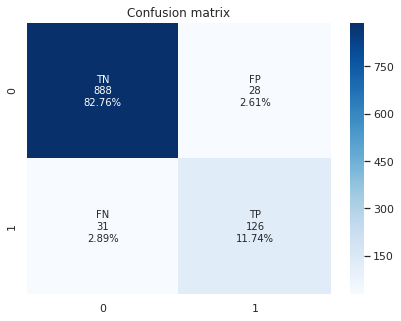

In [87]:
y_pred_superspreader = []
for viral,untrust in list(zip(X_test_viral,y_pred)):
    if viral > viral_strenght_threshold and untrust > 0.05:  #viral_strenght_threshold
        y_pred_superspreader.append(1)
    else:
        y_pred_superspreader.append(0)        
    
get_test_metrics(y_test_superspreader, y_pred_superspreader, full_metrics = True)

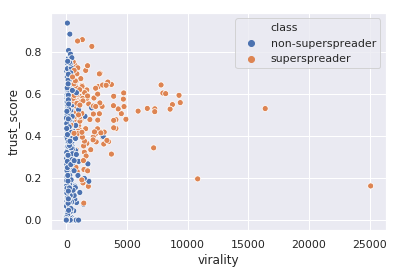

In [88]:
superspreader = ['superspreader' if x==1 else 'non-superspreader' for x in y_test_superspreader]
df_plot = pd.DataFrame({'virality':X_test_viral, 'trust_score':y_pred, 'class':superspreader})
sns.scatterplot(data=df_plot, x="virality", y="trust_score", hue = "class")